In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading data

In [2]:
buildings = pd.read_csv("../data/buildings.csv")

In [3]:
events = pd.read_csv("../data/events.csv")

In [4]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0
1,26200 mich ave inkster mi 48141,0,[116216],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1


In [5]:
events.head(2)

,event_id,lon,lat,addr,type
0,0,-83.161039,42.383998,13120-13130 ilene st,1
1,1,-83.080919,42.440471,1485 e outer dr,1


In [6]:
events['type'].value_counts()   # types: 1: 311-calls, 2: crimes, 3: blight violations

3    307804
2    119394
1     19679
4      6315
Name: type, dtype: int64

Add counts for each type into buildings

In [2]:
def str_to_list(events_str):
    events_list = events_str.rstrip(']').lstrip('[').split(', ')
    return events_list

In [8]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [9]:
buildings['311-calls'] = np.zeros(buildings.shape[0])
buildings['crimes'] = np.zeros(buildings.shape[0])
buildings['blight_violations'] = np.zeros(buildings.shape[0])
buildings['permit_cnt'] = np.zeros(buildings.shape[0])

for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        event = int(event)
        event_type = events.loc[event,'type']
        if event_type == 1:
              buildings.loc[i, '311-calls'] += 1
        elif event_type == 2:
              buildings.loc[i, 'crimes'] += 1
        elif event_type == 3:
              buildings.loc[i, 'blight_violations'] += 1
        elif event_type == 4:
              buildings.loc[i, 'permit_cnt'] += 1
        else:
              print("unexpected event_type: %d in row %d" % (event_type, i))

In [10]:
buildings[['311-calls','crimes','blight_violations','permit_cnt']].describe()

,311-calls,crimes,blight_violations,permit_cnt
count,130727.000000,130727.000000,130727.000000,130727.000000
mean,0.134142,0.831328,0.760715,0.021373
std,0.390493,1.094696,0.958943,0.155434
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,12.000000,9.000000,12.000000,5.000000


### Normalize longitude and latitude

In [11]:
buildings['norm_lon'] = (buildings['lon'].copy() - np.mean(buildings['lon'].values))/np.std(buildings['lon'].values)
buildings['norm_lat'] = (buildings['lat'].copy() - np.mean(buildings['lat'].values))/np.std(buildings['lat'].values)

In [12]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687
1,26200 mich ave inkster mi 48141,0,[116216],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1,0.0,1.0,0.0,0.0,-1.898702,-2.553627


In [13]:
buildings.to_csv('../data/buildings_with_features.csv', index=False)

### Analysis features

In [2]:
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split

In [3]:
buildings = pd.read_csv('../data/buildings_with_features.csv')
balanced_data = pd.read_csv('../data/balanced_data.csv')
balanced_keys = pd.read_csv('../data/balanced_keys.csv')

In [4]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,['138721'],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687
1,26200 mich ave inkster mi 48141,0,['116216'],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1,0.0,1.0,0.0,0.0,-1.898702,-2.553627


In [5]:
balanced_data.head(3)

,addr,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,15360 tracey,"[448971, 118987]",42.403010,-83.180173,-83.180379,42.402908,-83.179968,42.403112,38754
1,4817 chopin,[143959],42.332660,-83.134467,-83.134672,42.332558,-83.134261,42.332762,60569
2,5300 wayburn st,[13405],42.400448,-82.955224,-82.955430,42.400346,-82.955019,42.400550,121589


In [6]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [7]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'crimes', 'blight_violations']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt'] 

In [8]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [10]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [11]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 0.8,
    'max_depth': 4,
    'min_child_weight': 0.04,
    'eta': 0.05,
    'objective':'binary:logistic',
    'eval_metric': 'auc'
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 2000

In [12]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

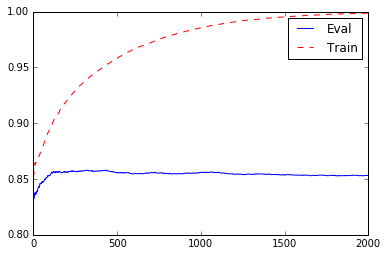

In [13]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [14]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [15]:
round(roc_auc_score(y_test, preds_proba), 5)

0.85838000000000003

In [16]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [17]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.845118	test-auc:0.836279
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.847263	test-auc:0.838641
[2]	train-auc:0.848587	test-auc:0.83879
[3]	train-auc:0.852187	test-auc:0.841268
[4]	train-auc:0.852356	test-auc:0.841304
[5]	train-auc:0.853007	test-auc:0.841514
[6]	train-auc:0.853515	test-auc:0.84179
[7]	train-auc:0.854986	test-auc:0.842854
[8]	train-auc:0.856128	test-auc:0.843156
[9]	train-auc:0.85749	test-auc:0.843773


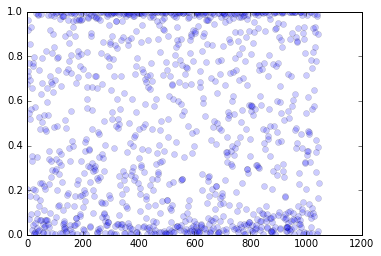

In [18]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [19]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

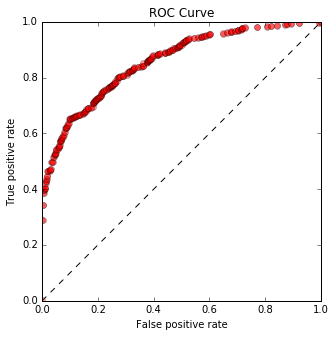

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

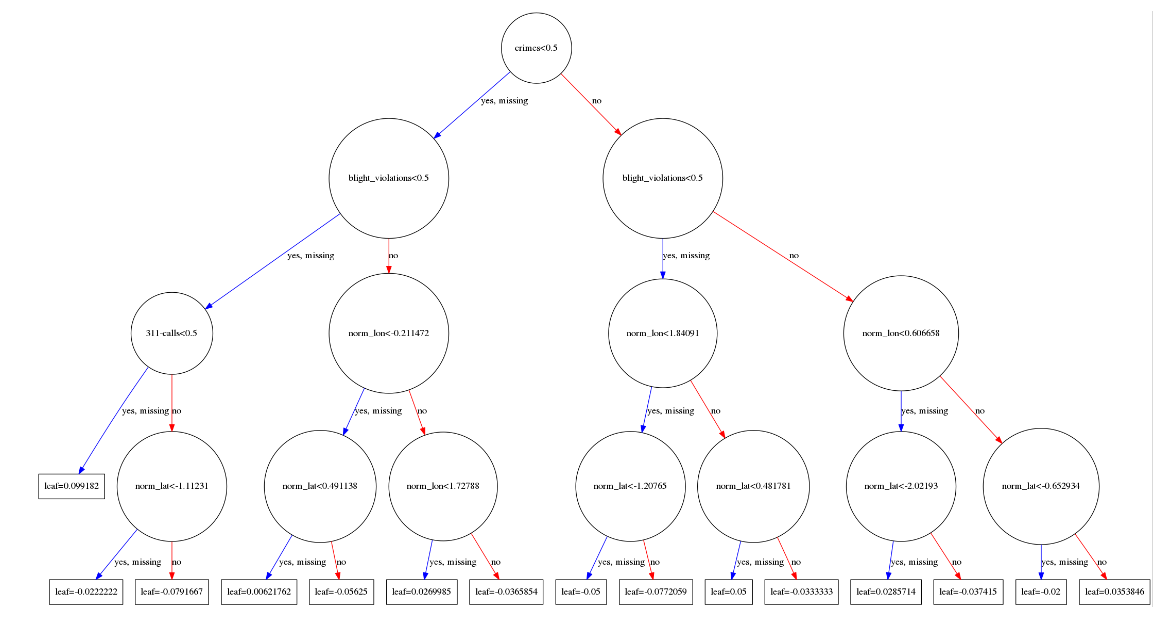

In [23]:
fig, ax = plt.subplots(figsize=(20,15), dpi=600)
xgb.plot_tree(bst, num_trees=0, ax=ax)
plt.show()

In [24]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [25]:
feat_names, feat_imps = zip(*feat_imp)

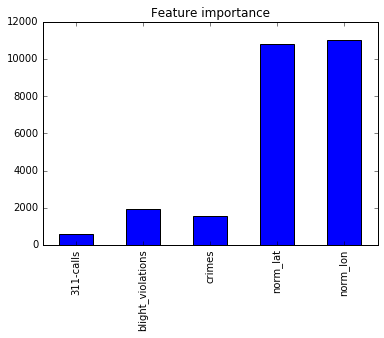

In [26]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

According to this simplified analysis, **location** has the most predictive power for blightness. ('norm_lat' and 'norm_lon' correspond to 'normalized latitude' and 'normalized longitude' respectively)

## More features from differentiating crimes

In [55]:
data_crimes = pd.read_csv('../data/data_crime.csv')

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
data_crimes.CATEGORY.unique()

array(['ASSAULT', 'LARCENY', 'STOLEN VEHICLE', 'WEAPONS OFFENSES',
       'TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS', 'BURGLARY',
       'AGGRAVATED ASSAULT', 'DAMAGE TO PROPERTY',
       'TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED', 'ROBBERY', 'FRAUD',
       'OBSTRUCTING JUDICIARY', 'DANGEROUS DRUGS', 'HOMICIDE',
       'SOLICITATION', 'OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE',
       'FAMILY OFFENSE', 'ARSON', 'ESCAPE', 'OBSTRUCTING THE POLICE',
       'RUNAWAY', 'BRIBERY', 'KIDNAPING', 'EXTORTION', 'OTHER BURGLARY',
       'STOLEN PROPERTY', 'HEALTH-SAFETY', 'VAGRANCY (OTHER)',
       'ENVIRONMENT', 'EMBEZZLEMENT', 'FORGERY', 'CONSPIRACY BY COMPUTER',
       'ANTITRUST', 'PUBLIC PEACE', 'LIQUOR', 'OUIL', 'OBSCENITY',
       'SOVEREIGNTY', 'TAX REVENUE', 'NEGLIGENT HOMICIDE', 'GAMBLING',
       'IMMIGRATION', 'CONGRESS', 'JUSTIFIABLE HOMICIDE', 'REVOKED',
       'ELECTION LAWS', 'DRUNKENNESS', 'FELONY DEATH FROM FLEEING VEHICLE',
       'MISCELLANEOUS ARREST', 'MILITARY'], dtype=ob

In [57]:
crime_categories = {'more_serious': ['ASSAULT', 'LARCENY', 'STOLEN VEHICLE', 'BURGLARY', 'AGGRAVATED ASSAULT',\
                    'ROBBERY', 'KIDNAPING', 'OTHER BURGLARY', 'NEGLIGENT HOMICIDE', 'JUSTIFIABLE HOMICIDE',\
                    'FELONY DEATH FROM FLEEING VEHICLE', 'DANGEROUS DRUGS', 'ARSON', 'HOMICIDE'], \
                   'less_serious': ['WEAPONS OFFENSES', 'TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS', \
                    'DAMAGE TO PROPERTY', 'TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED', 'FRAUD', 'OBSTRUCTING THE POLICE',\
                   'RUNAWAY', 'BRIBERY', 'EXTORTION', 'STOLEN PROPERTY', 'HEALTH-SAFETY', 'VAGRANCY (OTHER)', \
                    'ENVIRONMENT', 'EMBEZZLEMENT', 'FORGERY', 'CONSPIRACY BY COMPUTER', 'ANTITRUST', 'PUBLIC PEACE',\
                   'LIQUOR', 'OUIL', 'OBSCENITY', 'SOVEREIGNTY', 'TAX REVENUE', 'GAMBLING', 'IMMIGRATION', 'CONGRESS',\
                   'REVOKED', 'ELECTION LAWS', 'DRUNKENNESS', 'MISCELLANEOUS ARREST', 'MILITARY', 'SOLICITATION', \
                   'OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE', 'FAMILY OFFENSE', 'ESCAPE', 'OBSTRUCTING JUDICIARY']}

# based on data from gis.chicagopolice.org

In [58]:
data_crimes.head(2)

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,LON,LAT,LOCATION,addr,event_id,type
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,06/03/2015 12:00:00 AM,2,1007.0,10.0,City Council District 5,PETOSKEY-OTSEGO,5334.0,-83.1221,42.3678,"PETOSKEY\n09100\n(42.3676, -83.1219)",09100 petoskey,19679,2
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,03/01/2015 12:00:00 AM,9,608.0,6.0,City Council District 7,GRANDALE,5452.0,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\n(42.3725, -83.2033)",00 plymouth and mansfield,19680,2


In [59]:
def cat_crime(crime_str):
    '''numerical category: 
       ---- more_serious: 1
       ---- less_serious: 0
       ---- unclassified: -1
    '''
    if crime_str in crime_categories['more_serious']:
        return 1
    elif crime_str in crime_categories['less_serious']:
        return 0
    else:
        return -1

In [60]:
data_crimes['num_cat'] = data_crimes['CATEGORY'].apply(cat_crime)

In [61]:
data_crimes['num_cat'].unique()   # all crimes classified, no -1 encountered

array([1, 0])

In [62]:
buildings.head(1)  # refresher

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,['138721'],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687


In [63]:
less_serious_crime_event_ids = data_crimes.loc[data_crimes['num_cat']==0,'event_id'].values

In [64]:
more_serious_crime_event_ids = data_crimes.loc[data_crimes['num_cat']==1,'event_id'].values

In [69]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [70]:
buildings['less_serious_crimes'] = 0       # count of less serious crimes
buildings['more_serious_crimes'] = 0       # count of more serious crimes
buildings['event_id_list'] = buildings['event_id_list'].apply(lambda x: [int(i.rstrip("'").lstrip("'")) for i in x])

for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        if event in less_serious_crime_event_ids:
            buildings.loc[i, 'less_serious_crimes'] += 1
        elif event in more_serious_crime_event_ids:
            buildings.loc[i, 'more_serious_crimes'] += 1

In [71]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687,1,0


In [72]:
buildings.to_csv('../data/buildings_with_features_2.csv', index=False)

In [72]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [73]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'blight_violations', 'less_serious_crimes', 'more_serious_crimes']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes'] 

In [74]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [76]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [160]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 0.8,
    'max_depth': 4,
    'min_child_weight': 0.01,
    'eta': 0.05,
    'objective':'binary:logistic',
    'eval_metric': 'auc'
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 1000

In [161]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

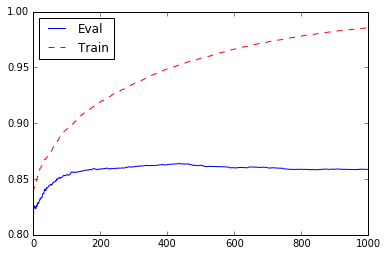

In [162]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [163]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [164]:
round(roc_auc_score(y_test, preds_proba), 5)

0.85733000000000004

In [165]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [166]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.830606	test-auc:0.823699
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.836317	test-auc:0.827503
[2]	train-auc:0.837251	test-auc:0.826546
[3]	train-auc:0.837361	test-auc:0.827453
[4]	train-auc:0.842004	test-auc:0.831273
[5]	train-auc:0.842466	test-auc:0.830971
[6]	train-auc:0.842457	test-auc:0.830695
[7]	train-auc:0.844221	test-auc:0.830072
Stopping. Best iteration:
[4]	train-auc:0.842004+0.00164892	test-auc:0.831273+0.0121094



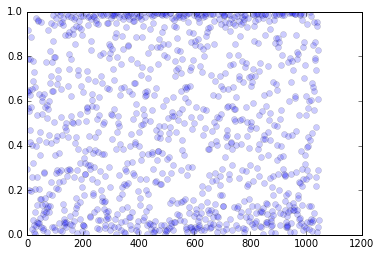

In [167]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [168]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

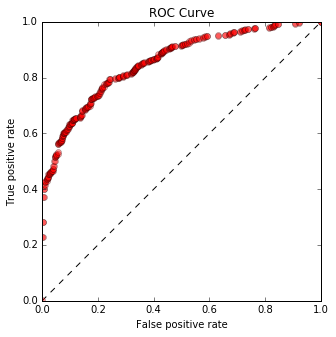

In [169]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [170]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [171]:
feat_names, feat_imps = zip(*feat_imp)

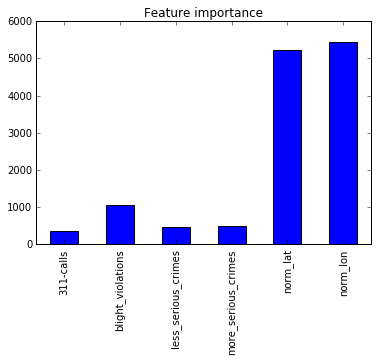

In [172]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

The additional feature created using differentiated crimes did not provide a better answer.

## SVM

In [173]:
# Train using another balanced data set (1:1 blighted vs nonblighted) with nonblighted of another list of random indexes
balanced_data_2 = pd.read_csv('../data/balanced_data_2.csv')
balanced_keys_2 = pd.read_csv('../data/balanced_keys_2.csv')

In [174]:
balanced_buildings_2 = buildings.loc[buildings['building_id'].isin(balanced_data_2['building_id'].values)].copy()

In [175]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'blight_violations', 'less_serious_crimes', 'more_serious_crimes']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes'] 

In [176]:
labels_2 = balanced_buildings_2['blighted']
data_2 = balanced_buildings_2.drop(names_to_drop, axis=1, inplace=False)

In [177]:
x_train, x_test, y_train, y_test = train_test_split(data_2, labels_2, test_size=0.2, stratify=labels, random_state=0)

In [178]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [179]:
from sklearn.svm import SVC

In [195]:
clf = SVC(C=1.0, kernel='rbf', probability=True)

In [196]:
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [199]:
y_pred_2 = clf.predict_proba(x_test)

In [200]:
round(roc_auc_score(y_test, y_pred_2[:,1]), 5)

0.83396000000000003

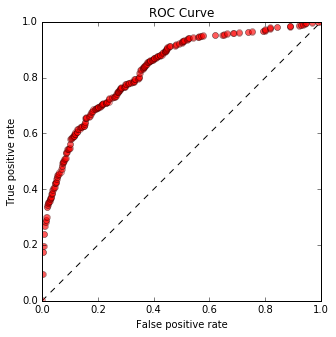

In [201]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2[:,1], pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

## More features from differentiating 'blight violations'

We still have only a very small number of features so far. And one should still benefit from exploring features.

In [73]:
data_violations = pd.read_csv('../data/data_bv.csv')

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
data_violations.columns

Index(['TicketID', 'TicketNumber', 'AgencyName', 'ViolName',
       'ViolationStreetNumber', 'ViolationStreetName', 'MailingStreetNumber',
       'MailingStreetName', 'MailingCity', 'MailingState', 'MailingZipCode',
       'NonUsAddressCode', 'Country', 'TicketIssuedDT', 'TicketIssuedTime',
       'HearingDT', 'CourtTime', 'ViolationCode', 'ViolDescription',
       'Disposition', 'FineAmt', 'AdminFee', 'LateFee', 'StateFee',
       'CleanUpCost', 'JudgmentAmt', 'PaymentStatus', 'Void',
       'ViolationCategory', 'ViolationAddress', 'MailingAddress', 'coord',
       'addr', 'lon', 'lat', 'event_id', 'type'],
      dtype='object')

In [75]:
data_violations.FineAmt.unique()     # this indicate importance of violations

array(['$1500.00', '$100.00', '$3500.00', '$200.00', '$2500.00', '$500.00',
       '$10000.00', '$1000.00', '$5000.00', '$250.00', '$25.00', '$300.00',
       '$50.00', '$750.00', '$20.00', '$125.00', '$1470.00', '$350.00',
       '$600.00', '$3000.00', '$1250.00', '$400.00', '$170.00', '$1750.00',
       '$1200.00', '$2000.00', '$970.00', '$7000.00', nan, '$150.00',
       '$2695.00', '$8000.00', '$95.00', '$345.00', '$270.00', '$30.00',
       '$450.00', '$160.00', '$220.00', '$375.00', '$1030.00', '$1.00',
       '$677.00', '$280.00', '$4000.00', '$90.00', '$290.00', '$370.00',
       '$1450.00', '$800.00', '$0.00', '$60.00', '$440.00', '$470.00',
       '$230.00'], dtype=object)

In [76]:
len(data_violations.ViolationCode.value_counts())   # Too many kind of violations if by category

265

In [243]:
buildings = pd.read_csv('../data/buildings_with_features_2.csv')
balanced_data = pd.read_csv('../data/balanced_data.csv')
balanced_keys = pd.read_csv('../data/balanced_keys.csv')

In [244]:
def get_num_amt(FineAmt):
    '''convert FineAmt string to numerical values'''
    amt_str = FineAmt.tolist()[0]
    if isinstance(amt_str, float):   # nan
        # print(amt_str)
        return 0
    amt_str = amt_str.lstrip('$')
    amt = float(amt_str)
    return amt 

In [245]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [246]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687,1,0


In [140]:
buildings['trivial_v'] = 0       # count of violation of minimal importance (< $100)
buildings['small_v'] = 0       # count of violation of small importance ($100 <= v < $1000 )
buildings['medium_v'] = 0      # count of violation with ($1000 <= v < $5000)
buildings['heavy_v'] = 0       # count of violation with (>=$5000)

buildings['event_id_list'] = buildings['event_id_list'].apply(lambda x: [int(i.rstrip("'").lstrip("'")) for i in x])

In [141]:
violation_events = data_violations['event_id'].values
for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        if event in violation_events:
            amt = get_num_amt(data_violations.loc[data_violations['event_id']==event, 'FineAmt'])
            if amt < 100:
                buildings.loc[i, 'trivial_v'] += 1
            elif amt >= 100 and amt < 1000:
                buildings.loc[i, 'small_v'] += 1
            elif amt >= 1000 and amt < 5000:
                buildings.loc[i, 'medium_v'] += 1
            elif amt >= 5000:
                buildings.loc[i, 'heavy_v'] += 1
            else: # nan
                buildings.loc[i, 'trivial_v'] += 1

In [142]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,...,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes,trivial_v,small_v,medium_v,heavy_v
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,...,0.0,0.0,-1.905905,-0.172687,1,0,0,0,0,0


In [143]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'less_serious_crimes', 'more_serious_crimes', 'trivial_v', 'small_v', 'medium_v', 'heavy_v']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes', 'blight_violations'] 

In [287]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [297]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [298]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [299]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [315]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 0.6,
    'max_depth': 4,
    'min_child_weight': 0.005,
    'eta': 0.01,
    'objective':'binary:logistic',
    'eval_metric': 'auc'
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 3000

In [316]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

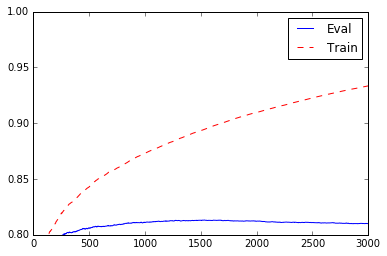

In [317]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [318]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [319]:
round(roc_auc_score(y_test, preds_proba), 5)

0.80254999999999999

In [314]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [170]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.804076	test-auc:0.794984
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.806266	test-auc:0.795802
[2]	train-auc:0.806756	test-auc:0.794448
[3]	train-auc:0.80755	test-auc:0.796157
[4]	train-auc:0.811246	test-auc:0.797917
[5]	train-auc:0.811655	test-auc:0.79817
[6]	train-auc:0.816066	test-auc:0.801006
[7]	train-auc:0.819737	test-auc:0.804629
[8]	train-auc:0.823159	test-auc:0.809775
[9]	train-auc:0.823798	test-auc:0.811035


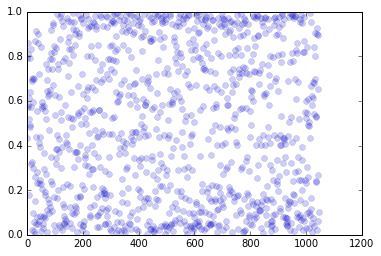

In [171]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [172]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

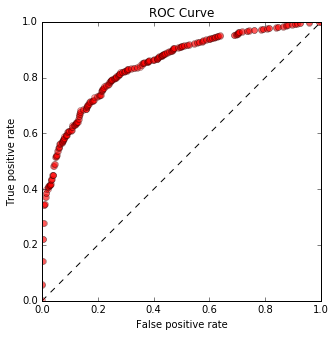

In [173]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [174]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [175]:
feat_names, feat_imps = zip(*feat_imp)

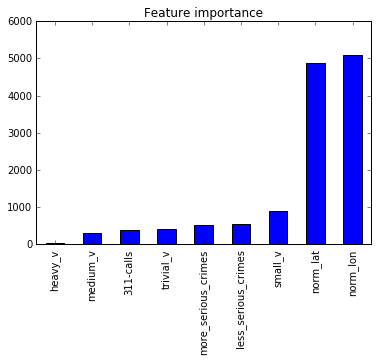

In [242]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)
feat_imp_vis.sort_values(inplace=True)
fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

## SVM

In [213]:
# Train using another balanced data set (1:1 blighted vs nonblighted) with nonblighted of another list of random indexes
balanced_data_2 = pd.read_csv('../data/balanced_data_2.csv')
balanced_keys_2 = pd.read_csv('../data/balanced_keys_2.csv')

In [226]:
balanced_buildings_2 = buildings.loc[buildings['building_id'].isin(balanced_data_2['building_id'].values)].copy()

In [227]:
feature_names = ['norm_lat', 'norm_lon', 'less_serious_crimes', 'more_serious_crimes', 'trivial_v', 'small_v', 'medium_v', 'heavy_v', '311-calls']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes', 'blight_violations'] 

In [228]:
labels_2 = balanced_buildings_2['blighted']
data_2 = balanced_buildings_2.drop(names_to_drop, axis=1, inplace=False)

In [229]:
x_train, x_test, y_train, y_test = train_test_split(data_2, labels_2, test_size=0.2, stratify=labels, random_state=0)

In [230]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [231]:
from sklearn.svm import SVC

In [237]:
clf = SVC(C=1.0, kernel='poly', probability=True)

In [238]:
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [239]:
y_pred_2 = clf.predict_proba(x_test)

In [240]:
round(roc_auc_score(y_test, y_pred_2[:,1]), 5)

0.77922999999999998

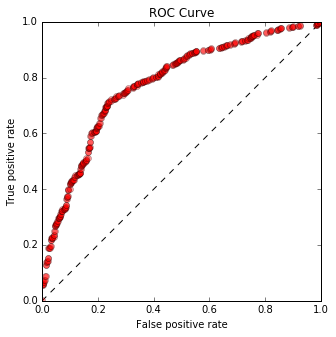

In [241]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2[:,1], pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

# Bagging with minimal number of features

More features produced by differentiating kinds of crimes or kinds of violations did not improve our power of predictions.
We can use bagging to predict result by using the average proba predicted by two models.

## Model 1: Tree

In [27]:
buildings = pd.read_csv('../data/buildings_with_features.csv')
balanced_data = pd.read_csv('../data/balanced_data.csv')
balanced_keys = pd.read_csv('../data/balanced_keys.csv')

In [28]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,['138721'],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687
1,26200 mich ave inkster mi 48141,0,['116216'],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1,0.0,1.0,0.0,0.0,-1.898702,-2.553627


In [29]:
balanced_data.head(3)

,addr,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,15360 tracey,"[448971, 118987]",42.403010,-83.180173,-83.180379,42.402908,-83.179968,42.403112,38754
1,4817 chopin,[143959],42.332660,-83.134467,-83.134672,42.332558,-83.134261,42.332762,60569
2,5300 wayburn st,[13405],42.400448,-82.955224,-82.955430,42.400346,-82.955019,42.400550,121589


In [30]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [31]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'crimes', 'blight_violations']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt'] 

In [32]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [34]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [35]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 0.8,
    'max_depth': 4,
    'min_child_weight': 0.04,
    'eta': 0.05,
    'objective':'binary:logistic',
    'eval_metric': 'auc'
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 2000

In [36]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

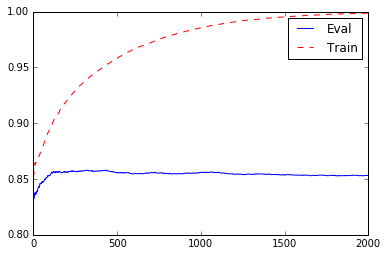

In [37]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.savefig('../data/train_process.png')
plt.show()

In [38]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [39]:
round(roc_auc_score(y_test, preds_proba), 5)

0.85838000000000003

In [40]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [41]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.845118	test-auc:0.836279
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.847263	test-auc:0.838641
[2]	train-auc:0.848587	test-auc:0.83879
[3]	train-auc:0.852187	test-auc:0.841268
[4]	train-auc:0.852356	test-auc:0.841304
[5]	train-auc:0.853007	test-auc:0.841514
[6]	train-auc:0.853515	test-auc:0.84179
[7]	train-auc:0.854986	test-auc:0.842854
[8]	train-auc:0.856128	test-auc:0.843156
[9]	train-auc:0.85749	test-auc:0.843773


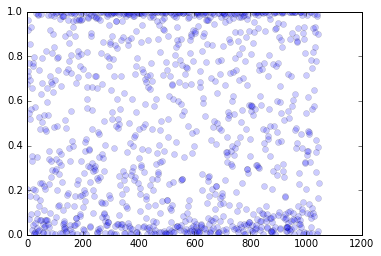

In [42]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [43]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

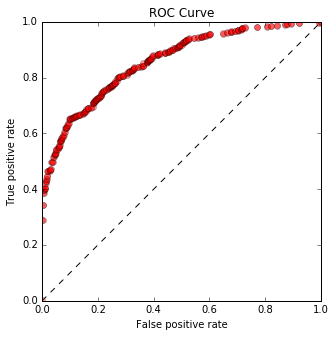

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

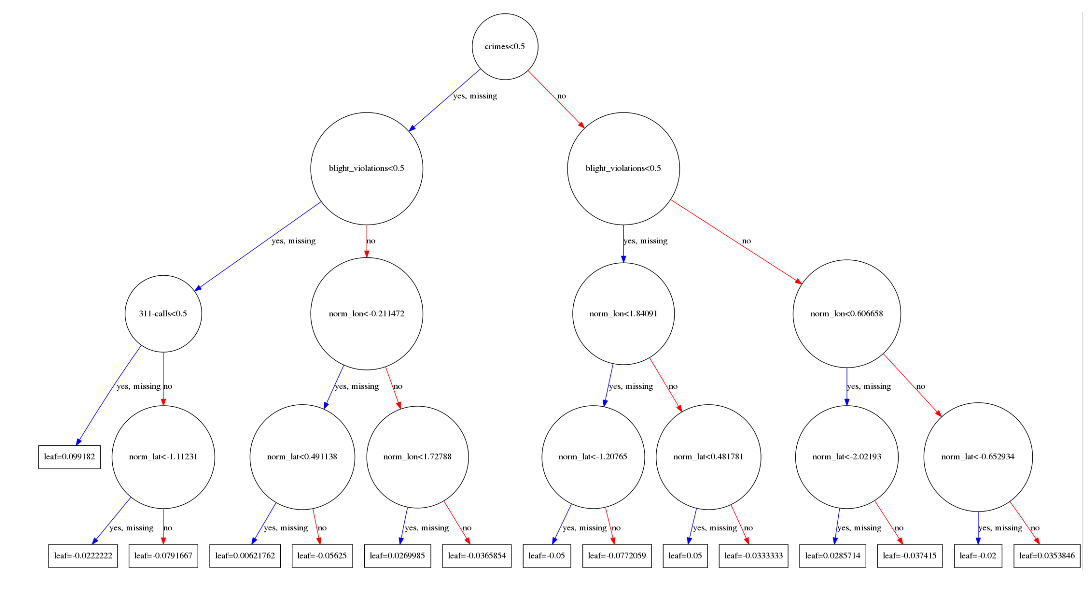

In [48]:
fig, ax = plt.subplots(figsize=(20,10), dpi=800)
xgb.plot_tree(bst, num_trees=0, ax=ax)
plt.savefig('../data/bst_tree.png')
plt.show()

In [381]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [382]:
feat_names, feat_imps = zip(*feat_imp)

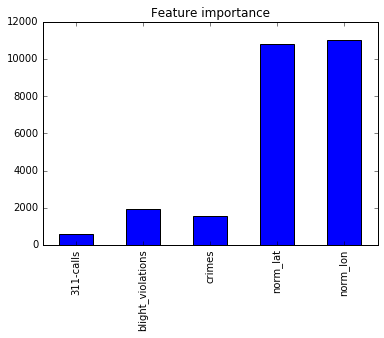

In [396]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')
plt.savefig('../data/feature_f_scores.png')
plt.show()

## Model 2: SVM

In [384]:
from sklearn.svm import SVC

In [385]:
clf = SVC(C=1.0, kernel='rbf', probability=True)

In [386]:
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [387]:
y_pred_2 = clf.predict_proba(x_test)

In [388]:
round(roc_auc_score(y_test, y_pred_2[:,1]), 5)

0.83630000000000004

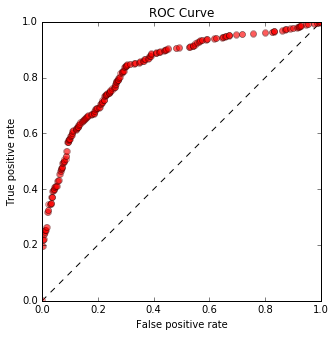

In [389]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2[:,1], pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

## Combined

In [390]:
# Prediction using the average score of two models built on training.
y_pred_combined = 0.5*(clf.predict_proba(x_test)[:,1] \
                       + bst.predict(xgb.DMatrix(x_test, label=y_test), ntree_limit=bst.best_ntree_limit))

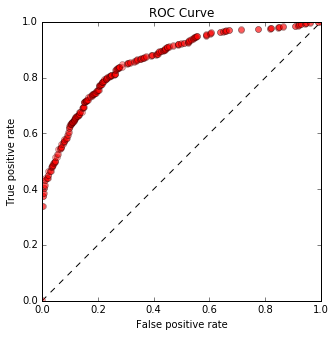

In [393]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_combined, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('../data/ROC_Curve_combined.png')
plt.show()

In [392]:
round(roc_auc_score(y_test, y_pred_combined), 5)

0.86470999999999998

+  Prediction using combined model of a tree and a svm resulted in a better result than either, achieving a AUC score of around **0.8647** on test data.